In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import special as sp
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy.constants import fine_structure, speed_of_light, electron_mass, elementary_charge, hbar
rng = np.random.default_rng()

In [2]:
#variáveis e constantes

num_pon = 50000                                                    #número de pontos
mean_ene = 1800                                                    #energia média inicial
std_div = 90                                                       #desvio padrão
mag_field = np.array([2.5*10**6, 2.5*10**5, 2.5*10**4, 2.5*10**3]) #[T] intensidade do campo magnético
chi_0 = 1                                                          #valor de chi máximo
tau_e = hbar/(speed_of_light**2*electron_mass)                     #[s] time it takes for light to travel across the electron radius
n_bins = 500                                                       #número de bins do histograma
t_end = np.array([3, 5, 20, 20])                                   #tempos finais
t_steps = 500                                                      #numero de steps

In [3]:
#valores de gamma
gamma_glob = mean_ene + std_div*rng.standard_normal(num_pon)

def cnst_prop_2(mag):
    return mag/(4.5*10**(9))

#definir a função h

def integration_func_h(x, X):
    return (2 * x ** 2 * sp.kv(5 / 3, x)) / (2 + 3 * x * X) ** 2 + (
                sp.kv(2 / 3, x) * 4 * x * (3 * x * X) ** 2) / (
                       2 + 3 * x * X) ** 4


def integration_h(X):
    return (9 * 3 ** 0.5 / (8 * pi)) * \
           integrate.quad(lambda x: integration_func_h(x, X), 0, np.Inf)[0]

chi_int = np.linspace(0.00001, chi_0*2, int(num_pon/10))

S = np.array([integration_h(x) for x in chi_int])

func_h = CubicSpline(chi_int, S)

#definir a função g

def integration_func_g(x, X):
    return (2 * x ** 3 * X**3 * sp.kv(5 / 3, x)) / (2 + 3 * x * X) ** 3 + (
                sp.kv(2 / 3, x) * 54 * x**4 * X ** 5) / (
                        2 + 3 * x * X) ** 5

def integration_g(X):
    return (9 * 3 ** 0.5 / (4 * pi)) * \
            integrate.quad(lambda x: integration_func_g(x, X), 0, np.Inf)[0]

R = np.array([integration_g(x) for x in chi_int])

func_g = CubicSpline(chi_int, R)

In [4]:
#aplicar o fokker-planck pusher
def beam_evolution(mag_field_0, gamma_glob_0, t_end_0):

    gamma_glob_1 = np.array(gamma_glob_0)

    for i in range(t_steps):

        time_step = t_end_0/t_steps

        omega_c = elementary_charge * mag_field_0 / (electron_mass * mean_ene)  #synchrotron frequency

        dW = np.sqrt(time_step) * np.random.randn(num_pon)

        d_gamma_1 = np.sqrt(func_g(gamma_glob_1*cnst_prop_2(mag_field_0))*((2/3)*fine_structure/tau_e/omega_c)*gamma_glob_1) * dW

        d_gamma_2 = func_h(gamma_glob_1*cnst_prop_2(mag_field_0))*((2/3)*fine_structure/tau_e/omega_c*(gamma_glob_1*cnst_prop_2(mag_field_0))**2) * time_step

        d_gamma = d_gamma_1 - d_gamma_2

        gamma_glob_1 += d_gamma

        #proibir gammas menores que 1 (impossibilidade física)
        for l in range(len(gamma_glob_0)):
            if(gamma_glob_1[l] <= 1):
                gamma_glob_1[l] = 1

        if i == int(t_steps/2) - 1:  #gamma em t = tend/2
            gamma_glob_2 = np.array(gamma_glob_1)  #gamma em t = tend/2

    return [gamma_glob_2, gamma_glob_1]

<ipython-input-5-e4c0bf6c5bd6>:7: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for i in tqdm(range(len(mag_field))):
100%|██████████| 4/4 [02:55<00:00, 43.79s/it]


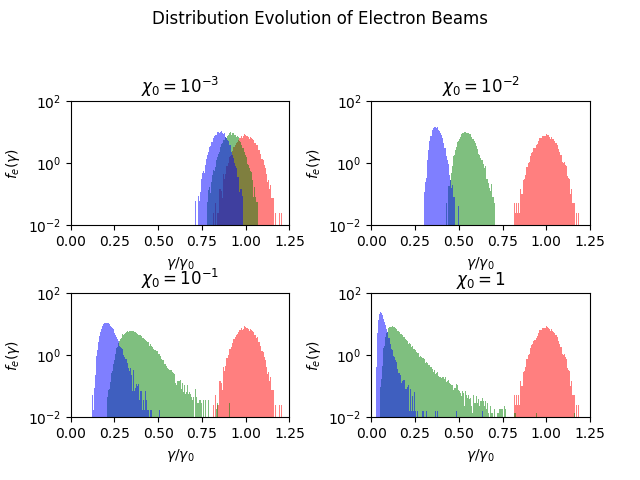

In [5]:
fig, axis = plt.subplots(2, 2)

fig.suptitle('Distribution Evolution of Electron Beams')

fig.tight_layout(pad=2.8)

for i in tqdm(range(len(mag_field))):

    #chi=1
    if (i==3):

        evolution = beam_evolution(mag_field[i], gamma_glob, t_end[i])

        #histograma em t=0
        axis[0, 0].hist(gamma_glob / mean_ene, n_bins, density=True,
                 color='red', alpha=0.5,
                 histtype='bar')

        #histograma em t = tend/2
        axis[0, 0].hist(evolution[0] / mean_ene, n_bins, density=True,
                 color='green', alpha=0.5,
                 histtype='bar')

        #histograma em t = tend
        axis[0, 0].hist(evolution[1] /mean_ene, n_bins, density=True,
                    color='blue', alpha=0.5,
                    histtype='bar')

    #chi=10^-1
    if (i == 2):
        # histograma em t=0

        evolution = beam_evolution(mag_field[i], gamma_glob, t_end[i])

        axis[0, 1].hist(gamma_glob / mean_ene, n_bins, density=True,
                        color='red', alpha=0.5,
                        histtype='bar')

        # histograma em t = tend/2
        axis[0, 1].hist(
            evolution[0] / mean_ene,
            n_bins, density=True,
            color='green', alpha=0.5,
            histtype='bar')

        # histograma em t = tend
        axis[0, 1].hist(
            evolution[1] / mean_ene,
            n_bins, density=True,
            color='blue', alpha=0.5,
            histtype='bar')

    #chi=10^-2
    if (i == 1):

        evolution = beam_evolution(mag_field[i], gamma_glob, t_end[i])

        # histograma em t=0
        axis[1, 0].hist(gamma_glob / mean_ene, n_bins, density=True,
                        color='red', alpha=0.5,
                        histtype='bar')

        # histograma em t = tend/2
        axis[1, 0].hist(
            evolution[0] / mean_ene,
            n_bins, density=True,
            color='green', alpha=0.5,
            histtype='bar')

        # histograma em t = tend
        axis[1, 0].hist(
            evolution[1] / mean_ene,
            n_bins, density=True,
            color='blue', alpha=0.5,
            histtype='bar')

    #chi=10^-3
    if (i == 0):

        evolution = beam_evolution(mag_field[i], gamma_glob, t_end[i])

        # histograma em t=0
        axis[1, 1].hist(gamma_glob / mean_ene, n_bins, density=True,
                        color='red', alpha=0.5,
                        histtype='bar')

        # histograma em t = tend/2
        axis[1, 1].hist(
            evolution[0] / mean_ene,
            n_bins, density=True,
            color='green', alpha=0.5,
            histtype='bar')

        # histograma em t = tend
        axis[1, 1].hist(
            evolution[1] / mean_ene,
            n_bins, density=True,
            color='blue', alpha=0.5,
            histtype='bar')
        
axis[0, 0].set_yscale('log')

axis[0, 0].set_xlim([0, 1.25])
axis[0, 0].set_ylim([0.01, 100])

axis[0, 0].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])

axis[0, 0].set_title('$\chi_{0}=10^{-3}$')

axis[0, 0].set_xlabel('${\gamma}/{\gamma_0}$')
axis[0, 0].set_ylabel('$f_e(\gamma)$')
        
axis[0, 1].set_yscale('log')

axis[0, 1].set_xlim([0, 1.25])
axis[0, 1].set_ylim([0.01, 100])

axis[0, 1].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])

axis[0, 1].set_title('$\chi_{0}=10^{-2}$')

axis[0, 1].set_xlabel('${\gamma}/{\gamma_0}$')
axis[0, 1].set_ylabel('$f_e(\gamma)$')
        
axis[1, 0].set_yscale('log')

axis[1, 0].set_xlim([0, 1.25])
axis[1, 0].set_ylim([0.01, 100])

axis[1, 0].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])

axis[1, 0].set_title('$\chi_{0}=10^{-1}$')

axis[1, 0].set_xlabel('${\gamma}/{\gamma_0}$')
axis[1, 0].set_ylabel('$f_e(\gamma)$')
        
axis[1, 1].set_yscale('log')

axis[1, 1].set_xlim([0, 1.25])
axis[1, 1].set_ylim([0.01, 100])

axis[1, 1].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])

axis[1, 1].set_title('$\chi_{0}=1$')

axis[1, 1].set_xlabel('${\gamma}/{\gamma_0}$')
axis[1, 1].set_ylabel('$f_e(\gamma)$')

plt.show()